# The Cox-Ross-Rubinstein model

## By Zhao Tianyuan

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.special import comb, perm

In [2]:
# parameters of the market
S0 = 100 # initial capital
n = 50 # number of peroids
sigma = 0.3
r = 0.05 # interest rate
b = 0.05
T = 2 # final time of the model, unit:years

Consider the n-periods binoimial model
$$ u= u_n = \exp( b h_n+ \sigma\sqrt( h_n))\\
  d=d_n = \exp( b h_n- \sigma\sqrt( h_n))\\
  h_n = \frac{T}{n}$$
  
The vector of possible configurations of capital at time step j is
$$ \textbf{Sn}(T,n,b,\sigma,j)= S_0 u^{j-i} d^i,i=0,\dots,j
$$

In [3]:
def Sn( T, n, b, sigma, j):
    '''
    Compute all the possible capitals at time step j
    
    Args:
        T: total time
        n: number of periods
        sigma, b: parameters
        j: current time step
    
    Return:
        array, j+1 dimensional vector of possible prices at time j
    '''
    hn = T/n
    u = np.exp( b* hn+ sigma* np.sqrt( hn))
    d = np.exp( b* hn- sigma* np.sqrt( hn))
    return np.array( [ S0* u**( j- i)* d**i for i in range( j+ 1)])

Assume $g(s) = (s-K)^+$, the payoff of a European call option with maturity T and strike K is
$$ \textbf{Payoffn}(T,n,b,\sigma,K)= g(S^n_n- K)
$$

In [4]:
def Payoffn( T, n, b, sigma, K):
    '''
    Compute all the possible payoffs given strike K and maturity T
    
    Args:
        T: maturity
        n: number of periods
        sigma, b: parameters
        K: strike >= 0
    
    Return:
        array, payoff vector of the option at maturity T
    '''
    return np.maximum( 0, Sn( T, n, b, sigma, n)- K)

Let $r\geq 0$ be a constant interest rate. The price of the European call option at time 0 is
$$ \textbf{Calln}(T,n,r,b,\sigma,K) = e^{-rT}\sum_{j=0}^n g(S_0 u^{n-j} d^j)C_n^j q^{n-j} (1-q)^j
$$
where $q = \frac{e^{r\frac{T}{n}} - d}{u - d}$ deduced by the risk-neutral measure $\mathbb{Q}_{n}$.

In [5]:
def Calln( T, n, r, b, sigma, K):
    '''
    Compute the no-arbitrage price of the European call option
    
    Args:
        T: maturity
        n: number of periods
        r: constant interest rate
        sigma, b: parameters
        K: strike >= 0
    
    Return:
        scalar, price of the European call option at time 0
    '''
    hn = T /n
    Rn = np.exp( r* hn)
    u = np.exp( b* hn+ sigma* np.sqrt( hn))
    d = np.exp( b* hn- sigma* np.sqrt( hn))
    q = ( Rn- d)/ ( u- d)
    Qlist = np.array( [ comb( n, j)* (1- q)**j * q**(n- j) for j in range( n+ 1)])
    Payofflist = Payoffn( T, n, b, sigma, K)
    return 1./ np.exp( r* T)* Payofflist.dot( Qlist)

Consider the contingent claims
$$ B^n = g(S^n_n)
$$
Given the contingent claim at time step k+1, the contingent claim $B_k^n$ at time step k and the corresponding perfect hedging strategy are:
$$
B_{k}^{n} :=\mathbb{E}_{k}^{\mathbb{Q}_{n}}\left[\overline{B}_{k+1}^{n}\right]~~\text{and }~~\theta_{k}^{n}\left(\omega_{k}\right)=\frac{B_{k+1}^{n}\left(\omega_{k}, u_{n}\right)-B_{k+1}^{n}\left(\omega_{k}, d_{n}\right)}{u_{n} S_{k}^{n}\left(\omega_{k}\right)-d_{n} S_{k}^{n}\left(\omega_{k}\right)}
$$

In [6]:
def Deltan( T, n, r, b, sigma, K, j):
    '''
    Compute the hedging strategy corresponding to the European call option at time step j
    
    Args:
        T: maturity
        n: number of periods
        r: constant interest rate
        sigma, b: parameters
        K: strike >= 0
        j: current time step
    
    Return:
        j+1 dimensional vector 
    '''
    hn = T /n
    R = np.exp( r* hn)
    u = np.exp( b* hn+ sigma* np.sqrt( hn))
    d = np.exp( b* hn- sigma* np.sqrt( hn))
    q = ( R- d)/ ( u- d)
    
    B_next = Payoffn( T, n, b, sigma, K)
    for i in range( n- 1, j, -1):
        B_next = B_next/ np.exp( r* ( i+ 1)* hn)
        B_next = B_next[ : -1]* q + B_next[ 1: ]* ( 1- q)
    Diff_B = B_next[ : -1] - B_next[ 1: ]
    
    S = Sn( T, n, b, sigma, j)
    
    return Diff_B/( ( u- d)* S)

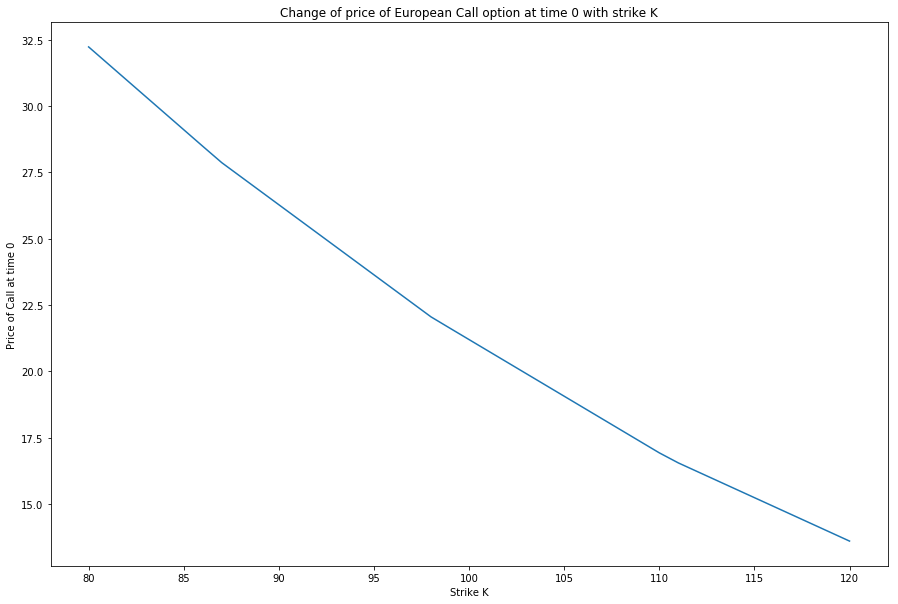

In [7]:
Klist = list( range( 80, 121))

Calllist = [ Calln( T, n, r, b, sigma, K) for K in Klist]
plt.figure(figsize=(15,10))
plt.plot( Klist, Calllist)
plt.xlabel("Strike K")
plt.ylabel("Price of Call at time 0")
plt.title("Change of price of European Call option at time 0 with strike K")
plt.show()

We observe that the price of the European Call option decreases as strike K augments which satisfies the no dominance principle and the convexity of the function curve.

## j = 15

In [8]:
j = 15
Deltanlist = [ Deltan( T, n, r, b, sigma, K, j) for K in Klist]

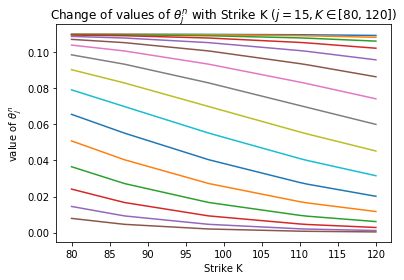

In [9]:
plt.plot( Klist, Deltanlist)
plt.xlabel('Strike K')
plt.ylabel('value of $\\theta_j^n$')
plt.title('Change of values of $\\theta_j^n$ with Strike K ($j=15,K\\in[80,120]$)')
plt.show()

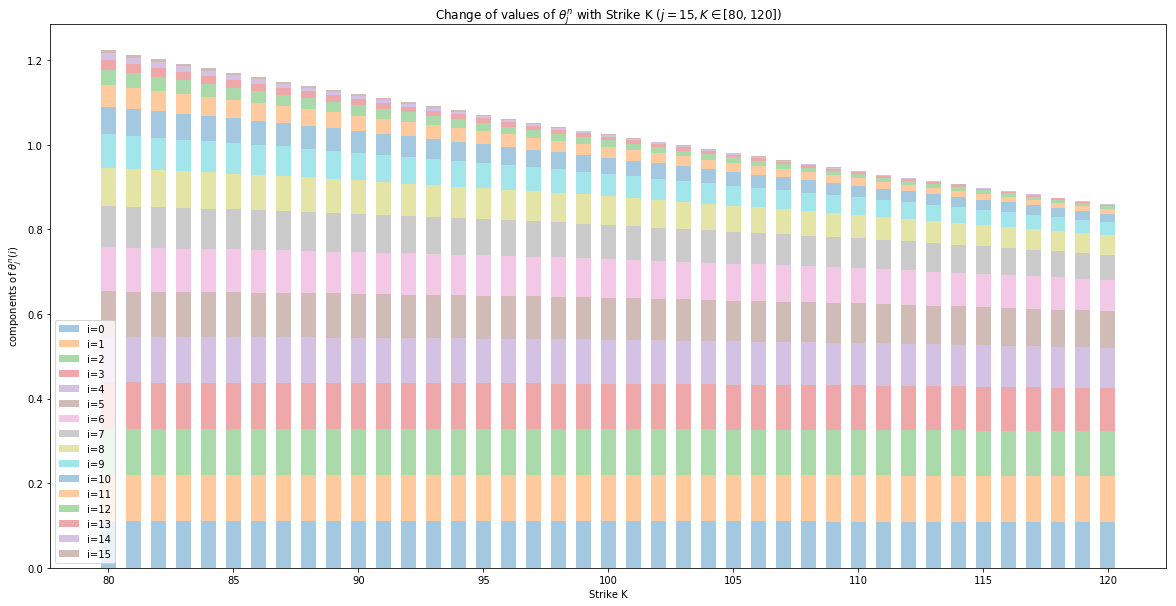

In [10]:
DeltanData = np.array( Deltanlist).T
plt.figure(figsize=(20,10))
bar_width = 0.6
opacity = 0.4

base = np.zeros( len( Klist))
for i, bar in enumerate( DeltanData):
    plt.bar(Klist, bar, bar_width,
            alpha=opacity,
            bottom=base,
            label='i={}'.format(i)
           )
    base += bar
    
plt.legend()
plt.xlabel('Strike K')
plt.ylabel('components of $\\theta_j^n(i)$')
plt.title('Change of values of $\\theta_j^n$ with Strike K ($j=15,K\\in[80,120]$)')
plt.show()

## j = 5

In [11]:
j = 5
Deltanlist = [ Deltan( T, n, r, b, sigma, K, j) for K in Klist]

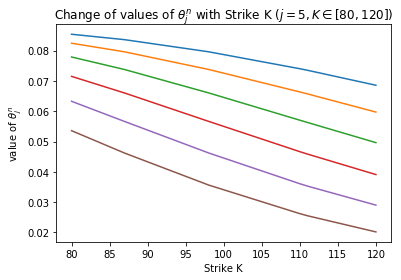

In [12]:
plt.plot( Klist, Deltanlist)
plt.xlabel('Strike K')
plt.ylabel('value of $\\theta_j^n$')
plt.title('Change of values of $\\theta_j^n$ with Strike K ($j=5,K\\in[80,120]$)')
plt.show()

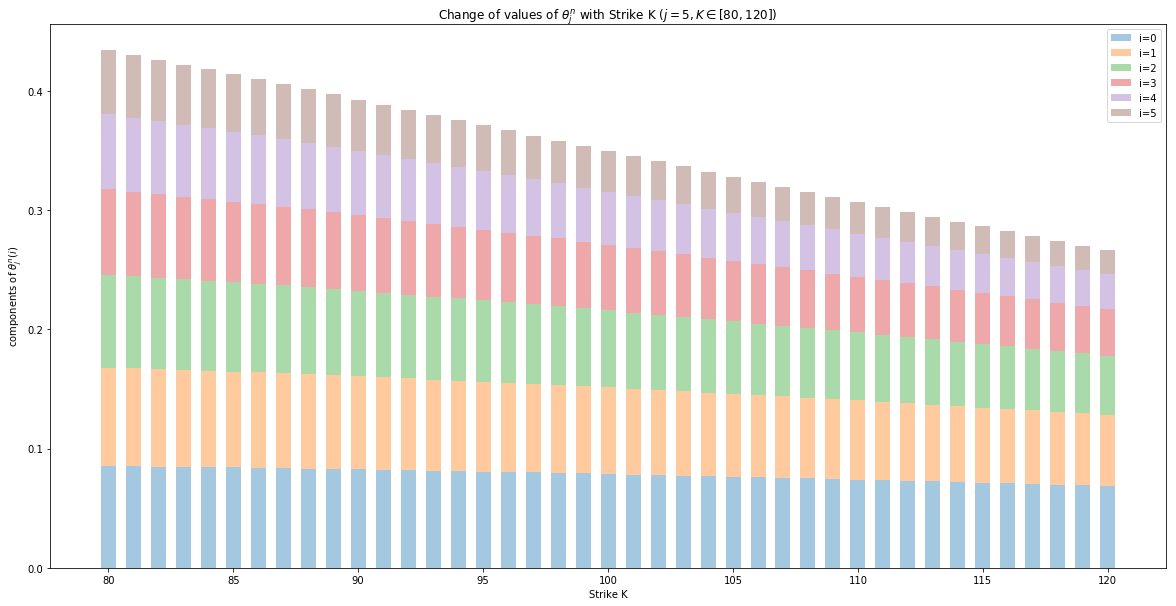

In [13]:
DeltanData = np.array( Deltanlist).T
plt.figure(figsize=(20,10))
bar_width = 0.6
opacity = 0.4

base = np.zeros( len( Klist))
for i, bar in enumerate( DeltanData):
    plt.bar(Klist, bar, bar_width,
            alpha=opacity,
            bottom=base,
            label='i={}'.format(i)
           )
    base += bar
    
plt.legend()
plt.xlabel('Strike K')
plt.ylabel('components of $\\theta_j^n(i)$')
plt.title('Change of values of $\\theta_j^n$ with Strike K ($j=5,K\\in[80,120]$)')
plt.show()

We observe that bigger the strike is, fewer shares of risky asset we should buy in all the possible configurations.

## Limiting Black-Scholes formula

In [14]:
def Call( T, r, sigma, K):
    '''
    Compute the Black-Scholes price of European call option at time 0
    
    Args:
        T: maturity
        r: constant interest rate
        sigma: parameter
        K: strike at maturity T
    
    Return:
        scalar
    '''
    Khat = K/ np.exp( r* T)
    v = sigma**2 * T
    dplus = np.log( S0/ Khat)/ np.sqrt( v)+ np.sqrt( v)/2.
    dminus = np.log( S0/ Khat)/ np.sqrt( v)- np.sqrt( v)/2.
    
    return S0* sps.norm.cdf( dplus)- Khat* sps.norm.cdf( dminus)


def err( T, n, r, b, sigma, K):
    '''
    Relative error between the finite differences approximation and the continous Black-Scholes solution
    
    Return:
        scalar, Calln/Call - 1
    '''
    return Calln( T, n, r, b, sigma, K)/ Call( T, r, sigma, K) - 1

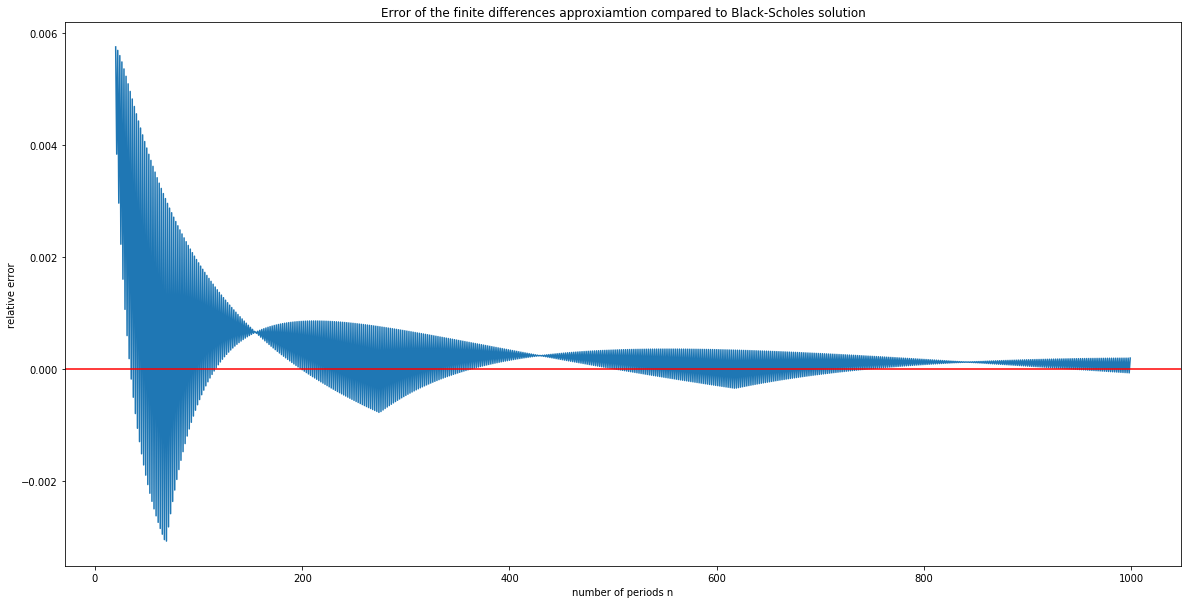

In [15]:
K = 105
nlist = list( range( 20,1000))
errlist = [ err( T, n, r, b, sigma, K) for n in nlist]
plt.figure(figsize=(20,10))
plt.plot( nlist, errlist)
plt.axhline(y=0, c='r')
#plt.xlim([0,20])
plt.xlabel( 'number of periods n')
plt.ylabel( 'relative error')
plt.title('Error of the finite differences approxiamtion compared to Black-Scholes solution')
plt.show()

We observe that the finite difference approximation approach the limite Black-Scholes formula solution when n gets large which illustrate that the limit of the discrete-time valuation formula coincides with the Black-Scholes formula.